In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
import gc  # Garbage Collector zur Speicherverwaltung
import sys
sys.path.append(os.path.abspath("../../"))
from eval_call import evaluate_model



df = pd.read_csv('../../data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                251079 non-null  int64  
 1   brand                     251079 non-null  object 
 2   model                     251079 non-null  object 
 3   color                     250913 non-null  object 
 4   registration_date         251075 non-null  object 
 5   year                      251079 non-null  object 
 6   price_in_euro             251079 non-null  object 
 7   power_kw                  250945 non-null  object 
 8   power_ps                  250950 non-null  object 
 9   transmission_type         251079 non-null  object 
 10  fuel_type                 251079 non-null  object 
 11  fuel_consumption_l_100km  224206 non-null  object 
 12  fuel_consumption_g_km     251079 non-null  object 
 13  mileage_in_km             250927 non-null  f

In [5]:
import sys
import os

sys.path.append(os.path.abspath("../.."))
from Preprocessing.DropAll_preprocessing_pipeline import preprocessing_pipeline

df = preprocessing_pipeline(df)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178095 entries, 0 to 222896
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     178095 non-null  object 
 1   model                     178095 non-null  object 
 2   color                     178095 non-null  object 
 3   price_in_euro             178095 non-null  int64  
 4   power_ps                  178095 non-null  float64
 5   transmission_type         178095 non-null  object 
 6   fuel_type                 178095 non-null  object 
 7   fuel_consumption_l_100km  178095 non-null  float64
 8   mileage_in_km             178095 non-null  float64
 9   age                       178095 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 14.9+ MB


In [7]:
from sklearn.model_selection import train_test_split

y = df['price_in_euro']
X = df.drop(['price_in_euro'], axis=1)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # Scaling is crucial for KNN
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



final_knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(
        n_neighbors=4,
        weights='distance',  
        algorithm='auto',
        p = 2, #Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.
        n_jobs=-1  
    ))
])


print("\nTraining KNN model ...")
final_knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_knn = final_knn_pipeline.predict(X_test)

# Evaluate model
evaluate_model(y_test, y_pred_knn, "KNN Regression")


# Clean up memory
gc.collect()





Training KNN model ...
KNN Regression Performance Metrics:
MAE: 3742.94
MSE: 191528123.06
RMSE: 13839.37
R²: 0.81
------------------------------


484

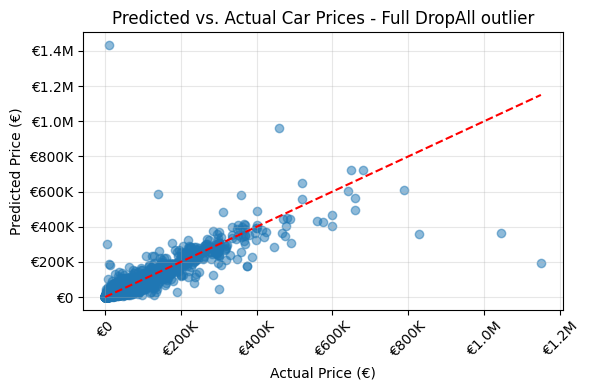

In [9]:
from matplotlib.ticker import FuncFormatter


plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  
plt.xlabel('Actual Price (€)')
plt.ylabel('Predicted Price (€)')
plt.title('Predicted vs. Actual Car Prices - Full DropAll outlier')


plt.grid(True, alpha=0.3)


def euros(x, pos):
    if x >= 1000000:
        return f'€{x/1000000:.1f}M'
    elif x >= 1000:
        return f'€{x/1000:.0f}K'
    else:
        return f'€{int(x)}'
    
plt.gca().xaxis.set_major_formatter(FuncFormatter(euros))
plt.gca().yaxis.set_major_formatter(FuncFormatter(euros))

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

In [10]:
import shap

In [11]:
# Create feature names list for SHAP plot
all_feature_names = []
# Add numeric feature names
all_feature_names.extend(numeric_features)
# Add encoded categorical feature names
for i, cat_feature in enumerate(categorical_features):
    # Since we're using OrdinalEncoder, we'll append the category name
    all_feature_names.append(cat_feature)

In [12]:
all_feature_names

['power_ps',
 'fuel_consumption_l_100km',
 'mileage_in_km',
 'age',
 'brand',
 'model',
 'color',
 'transmission_type',
 'fuel_type']

In [15]:
# Create SHAP explainer with feature names
model = final_knn_pipeline.named_steps['model']


In [14]:
X_test_sampled = shap.sample(X_test, 50)
X_test_sampled


,brand,model,color,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,mileage_in_km,age
29454,bmw,BMW 530,blue,258.0,Automatic,Diesel,5.3,182092.0,10
120796,nissan,Nissan Tiida,silver,110.0,Manual,Petrol,6.9,147007.0,14
86383,maserati,Maserati Quattroporte,black,275.0,Automatic,Diesel,6.2,59000.0,7
41447,citroen,Citroen C1,grey,68.0,Manual,Petrol,4.5,62000.0,9
167357,seat,SEAT Arona,grey,110.0,Manual,Petrol,4.8,20.0,1
87027,mazda,Mazda 3,grey,150.0,Manual,Petrol,6.8,123000.0,12
201147,volkswagen,Volkswagen Golf,blue,86.0,Manual,Petrol,4.9,130250.0,9
207448,volkswagen,Volkswagen Passat,grey,190.0,Automatic,Diesel,4.6,200000.0,6
215550,volkswagen,Volkswagen Passat Variant,black,200.0,Automatic,Diesel,6.4,22000.0,2
217208,volkswagen,Volkswagen Arteon,black,200.0,Automatic,Diesel,4.7,16971.0,1


In [30]:
X_processed = final_knn_pipeline.named_steps['preprocessor'].transform(X_test_sampled)

In [34]:
explainer = shap.KernelExplainer(model.predict, X_processed)

100%|██████████| 50/50 [4:18:16<00:00, 309.94s/it]  
C:\Users\kilia\AppData\Local\Temp\ipykernel_7644\2419727009.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_processed)


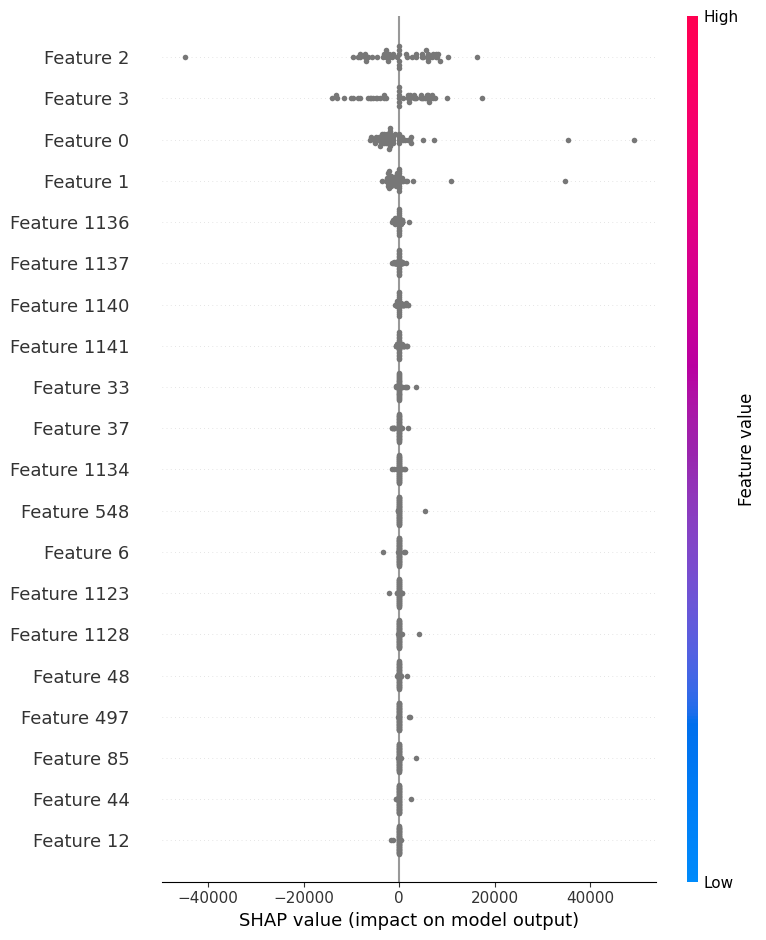

In [35]:
shap_values = explainer.shap_values(X_processed)
shap.summary_plot(shap_values, X_processed)


In [13]:
import shap

# Sample a subset of data for background (for computational efficiency)
X_full_sampled = shap.sample(X, 50)

# Process the sampled data through the preprocessing pipeline
X_full_processed_sampled = final_knn_pipeline.named_steps['preprocessor'].transform(X_full_sampled)

# Create SHAP explainer with feature names
model = final_knn_pipeline.named_steps['model']

# Create the explainer with the preprocessed background data
full_data_explainer = shap.KernelExplainer(model.predict, X_full_processed_sampled)

# Process the full X data for SHAP analysis
X_full_processed = final_knn_pipeline.named_steps['preprocessor'].transform(X)

# Calculate SHAP values for the processed data
full_data_shap_values = full_data_explainer.shap_values(X_full_processed)


  0%|          | 0/178095 [02:19<?, ?it/s]


KeyboardInterrupt: 

In [14]:
X_processed = final_knn_pipeline.named_steps['preprocessor']
X_processed

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['power_ps', 'fuel_consumption_l_100km',
                                  'mileage_in_km', 'age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['brand', 'model', 'color',
                                  'transmission_type', 'fuel_type'])])

In [ ]:
import shap
# Sample a small subset of X_test for background data efficiency if needed 
# (X_test_sampled is already defined in the environment)

X_test_sampled = shap.sample(X_test, 50)

# Create a preprocessed background dataset for the explainer
X_processed_sampled = final_knn_pipeline.named_steps['preprocessor'].transform(X_test_sampled)

# Define a prediction function for the explainer that handles sparse matrices
def model_predict(X):
    # Convert to dense array if it's sparse
    if hasattr(X, "toarray"):
        X = X.toarray()
    return final_knn_pipeline.named_steps['model'].predict(X)

# Create the explainer with the preprocessed data
explainer = shap.KernelExplainer(model_predict, X_processed_sampled)

# Process X_test before generating SHAP values
X_test_processed = final_knn_pipeline.named_steps['preprocessor'].transform(X_test)



# Generate SHAP values for the processed test data
shap_values = explainer.shap_values(X_test_processed)
print('SHAP Values for Full Dataset w/o Outliers')

# Create the summary plot
shap.summary_plot(shap_values, X_test)

  0%|          | 1/35619 [43:34<25863:28:08, 2614.09s/it]